# 02. Neural Network classification with PyTorch

Classification is a problem of prediction whether something is one thing or another (there can be multiple things as the options).

Book version: https://www.learnpytorch.io/02_pytorch_classification/ \\
Github: https://github.com/mrdbourke/pytorch-deep-learning


## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


<Axes: xlabel='X1', ylabel='X2'>

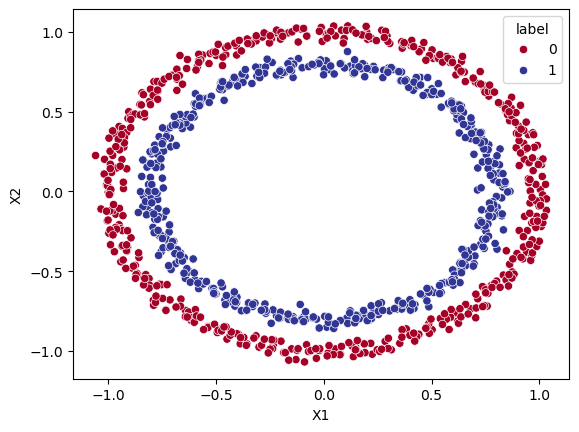

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
import seaborn as sns

# plt.scatter(x=X[:, 0],
#             y=X[:, 1],
#             c=y,
#             cmap=plt.cm.RdYlBu)
sns.scatterplot(
    data=circles, x="X1", y="X2", hue="label", palette="RdYlBu", hue_norm=(0, 1)
)

**Note:** The data we're working with is often reffed to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first examples of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(
    f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}"
)

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch

torch.__version__

'2.0.0.post302'

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 0.2 = 20% test, 80% train
)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on a GPU if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop


In [15]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `formard()` method that outlines the forward pass (or forward computation)  of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [16]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes our data
        self.layer_1 = nn.Linear(
            in_features=2, out_features=5
        )  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(
            in_features=5, out_features=1
        )  # takes in 5 feat. from prev. layer and outputs 1 feat. (same shape as y)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  #  x-> layer_1 -> layer_2 -> output


# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6038, -0.6933],
                      [ 0.0815,  0.1146],
                      [-0.1497, -0.4798],
                      [-0.4502,  0.0778],
                      [-0.5583, -0.3519]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2922,  0.5736, -0.1030,  0.2145,  0.0999], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0852, -0.0807, -0.1031,  0.2040, -0.1449]], device='cuda:0')),
             ('1.bias', tensor([-0.4035], device='cuda:0'))])

In [20]:
# Make predictions
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.3820],
        [-0.3895],
        [-0.4123],
        [-0.3732],
        [-0.4921],
        [-0.4961],
        [-0.4542],
        [-0.4794],
        [-0.4089],
        [-0.3909]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

This is problem specific

For regression, you might want MAE or MSE
For classification, you might want binary cross entropy and categorical cross entropy

As a reminder, the loss function measures how wrong the predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however, PyTorch has a lot of many built-in options

- For the loss function we're going to use `torch.nn.BCEWithLogitLoss()`, for more on what BCE is check out the article.

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

- For different optimizers, see `torch.optim`|


In [21]:
# Setup the loss function
loss_fn = (
    nn.BCEWithLogitsLoss()
)  # BCEwithLogitsLoss = sigmoid actionation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6038, -0.6933],
                      [ 0.0815,  0.1146],
                      [-0.1497, -0.4798],
                      [-0.4502,  0.0778],
                      [-0.5583, -0.3519]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2922,  0.5736, -0.1030,  0.2145,  0.0999], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0852, -0.0807, -0.1031,  0.2040, -0.1449]], device='cuda:0')),
             ('1.bias', tensor([-0.4035], device='cuda:0'))])

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train a model

To train our model, we need to build a training loop

1. Forward pass
2. Calculate the loss
3. Optimize the zero grad
4. Loss backward (back propagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into a prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

`logits` are raw output of the model without being passed to an activation function.



In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3820],
        [-0.3895],
        [-0.4123],
        [-0.3732],
        [-0.4921]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4057],
        [0.4038],
        [0.3983],
        [0.4078],
        [0.3794]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 2)

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Building a training and test loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # Activate train mode
    model_0.train()

    # 1. Foward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(
        torch.sigmoid(y_logits)
    )  # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #                y_train)
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. Foward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.71680, Acc: 50.00% | Test Loss: 0.71531, Test acc: 50.00%
Epoch: 10 | Loss: 0.70400, Acc: 50.00% | Test Loss: 0.70434, Test acc: 50.00%
Epoch: 20 | Loss: 0.69817, Acc: 50.00% | Test Loss: 0.69959, Test acc: 50.00%
Epoch: 30 | Loss: 0.69553, Acc: 50.00% | Test Loss: 0.69758, Test acc: 50.00%
Epoch: 40 | Loss: 0.69434, Acc: 43.50% | Test Loss: 0.69675, Test acc: 40.50%
Epoch: 50 | Loss: 0.69379, Acc: 47.75% | Test Loss: 0.69640, Test acc: 47.50%
Epoch: 60 | Loss: 0.69354, Acc: 48.88% | Test Loss: 0.69624, Test acc: 48.00%
Epoch: 70 | Loss: 0.69341, Acc: 49.62% | Test Loss: 0.69615, Test acc: 48.00%
Epoch: 80 | Loss: 0.69335, Acc: 49.75% | Test Loss: 0.69608, Test acc: 46.00%
Epoch: 90 | Loss: 0.69331, Acc: 50.38% | Test Loss: 0.69602, Test acc: 46.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything ...

So to inspect, let's make some predictions and make them visual!

Visualize, visualize, visualize !

To do so, we're going to import a function called plot_decision_boundary() - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py



In [29]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


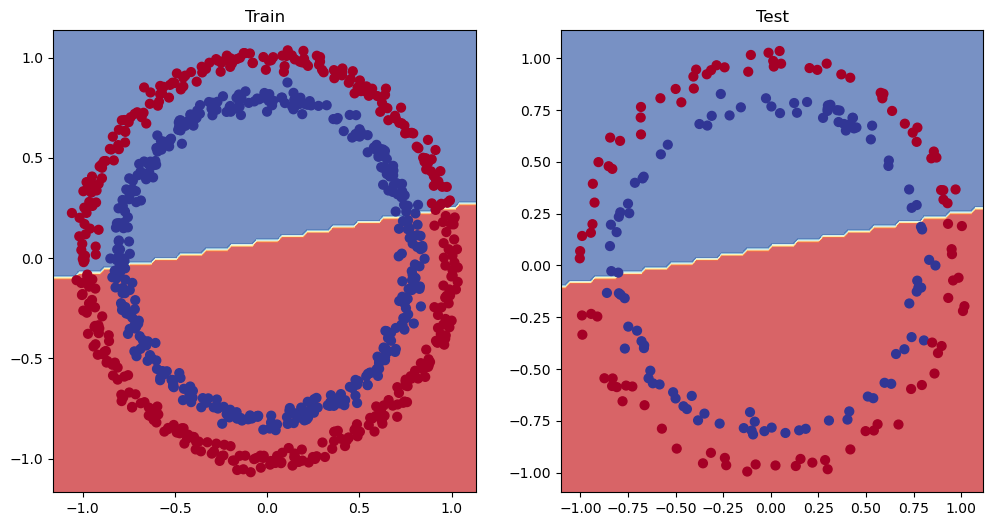

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model  (from a model perspective)

- Add more layers - give the model more changes to learn about patterns in the data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for a longer time
- Changing the activation functions
- Change the learning rate
- Change the loss rate

These options are all from a model's perspective because they deal directly with the model, rather than data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to **hyperparameters**

Let's try to improve our model by:
- Adding more hidden units: 5 -> 10
- Increase the number of layers: 2 -> 3
- Increase the number of epochs 100 -> 1000



In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        # return self.layer_3(self.layer_2(self.layer_1(x)))
        return z


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss function
loss_fn = (
    nn.BCEWithLogitsLoss()
)  # BCEwithLogitsLoss = sigmoid actionation function built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # Activate train mode
    model_1.train()

    # 1. Foward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(
        torch.sigmoid(y_logits)
    )  # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #                y_train)
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        # 1. Foward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


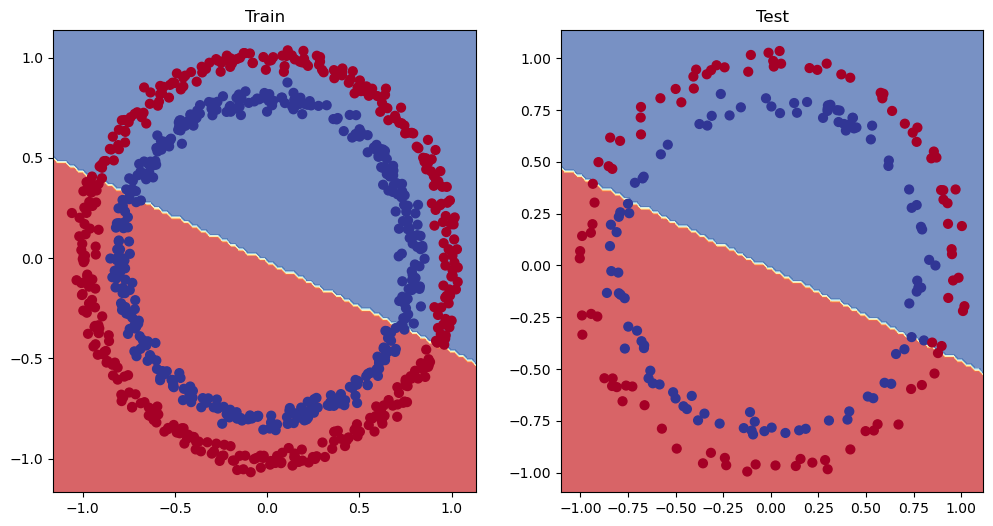

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [34]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias  # Linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [35]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = (
    X_regression[:train_split],
    y_regression[:train_split],
)
X_test_regression, y_test_regression = (
    X_regression[train_split:],
    y_regression[train_split:],
)

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(
    y_test_regression
)

(80, 80, 20, 20)

<Figure size 500x200 with 0 Axes>

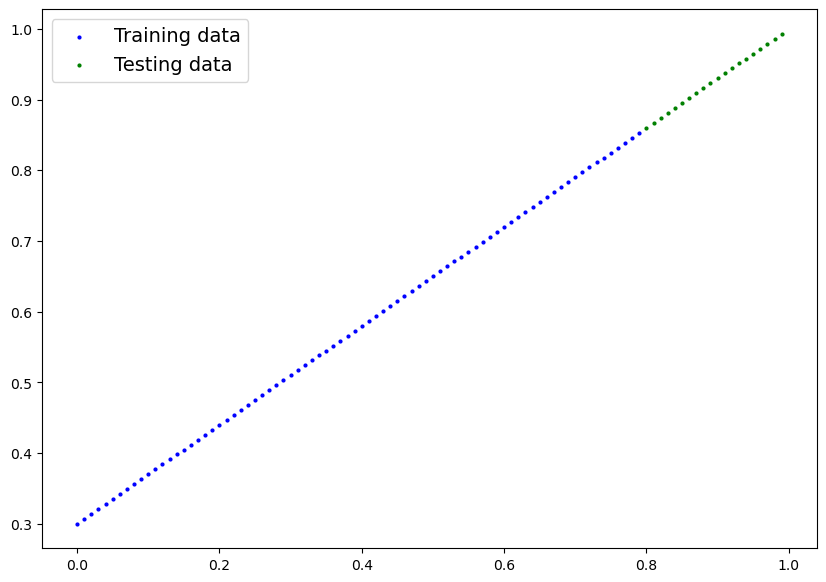

In [36]:
plt.figure(figsize=(5, 2))
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression,
)

### 5.2 Adjusting `model_1` to fir the straight line

In [37]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [39]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(
    device
), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(
    device
), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 1:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 1 | Loss: 0.72202 | Test loss: 0.86871
Epoch: 101 | Loss: 0.00821 | Test loss: 0.04439
Epoch: 201 | Loss: 0.01043 | Test loss: 0.04538
Epoch: 301 | Loss: 0.01343 | Test loss: 0.04523
Epoch: 401 | Loss: 0.01433 | Test loss: 0.04461
Epoch: 501 | Loss: 0.01383 | Test loss: 0.04284
Epoch: 601 | Loss: 0.01351 | Test loss: 0.04194
Epoch: 701 | Loss: 0.01310 | Test loss: 0.04120
Epoch: 801 | Loss: 0.01287 | Test loss: 0.04123
Epoch: 901 | Loss: 0.01268 | Test loss: 0.03958


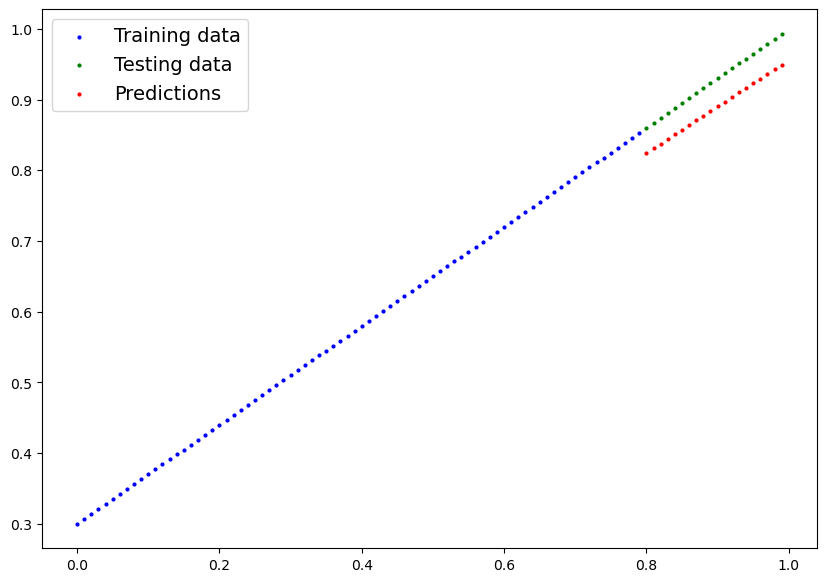

In [40]:
model_2.eval()
with torch.inference_mode():
    y_pred = model_2(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_pred.cpu(),
)

## 6. The missing piece: non-linearity

"what patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

or in machine liearning terms, an infinite (but really it is finite) of linear and non-linear functions

### 6.1 Recreting non-linear data (red and blue circles)


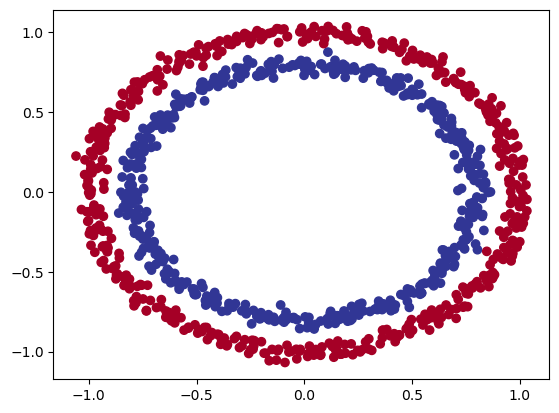

In [41]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn dta into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = Not straight line

In [43]:
# Build a model with non-linear activation functions
from torch import nn


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [45]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(
        torch.sigmoid(y_logits)
    )  # logitcs -> prediction probabilities ->

    # 2. Calculate the loss
    loss = loss_fn(
        y_logits, y_train
    )  # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # PRint out the output
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.62145, Test acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [46]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

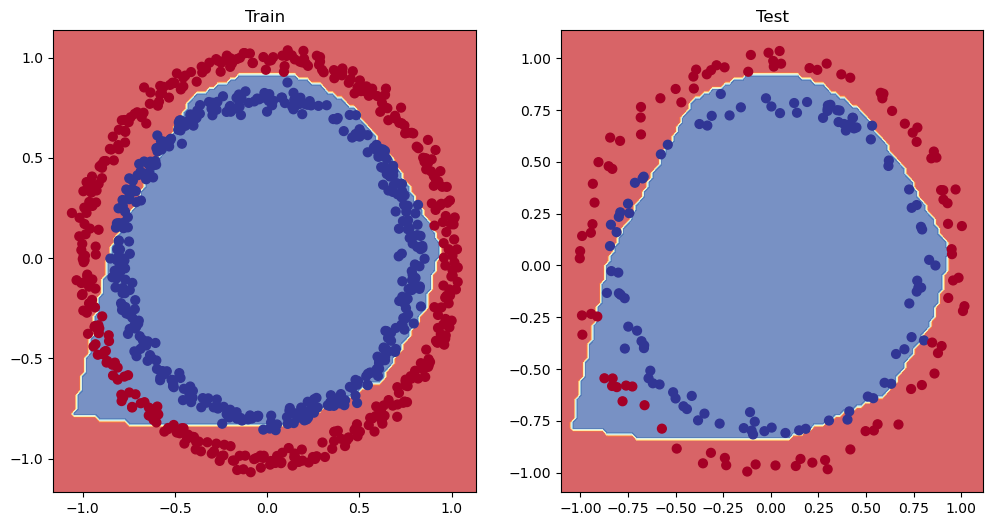

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patters in data and it tried to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [48]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

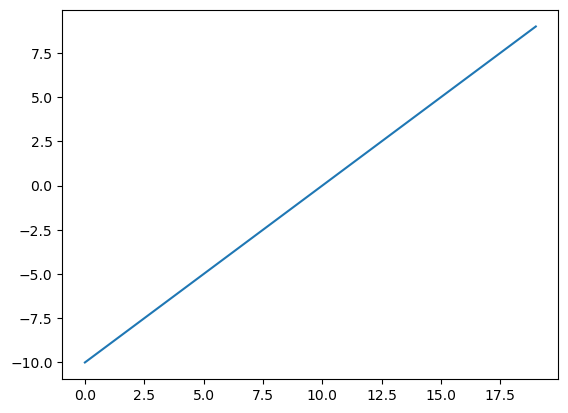

In [49]:
plt.plot(A)

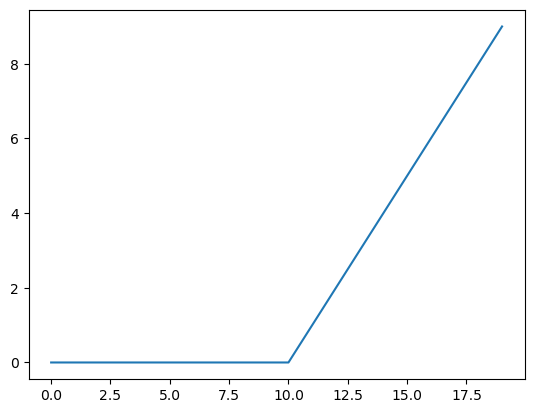

In [50]:
plt.plot(nn.ReLU()(A))

In [51]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)  # inputs must be tensors


relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

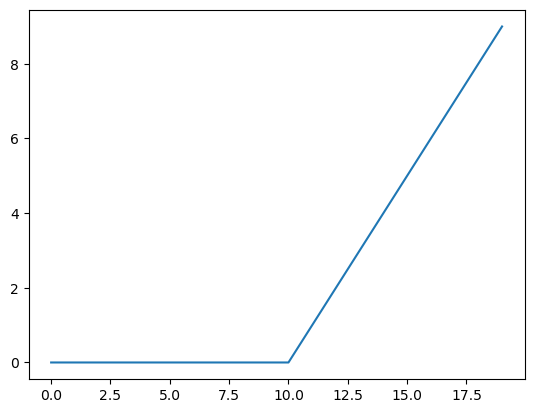

In [52]:
# Plot ReLUI activation function
plt.plot(relu(A))

In [53]:
# Now let's do the same for Sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))


sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

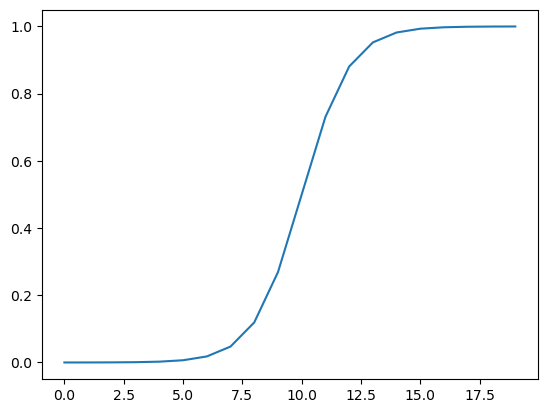

In [54]:
plt.plot(torch.sigmoid(A))

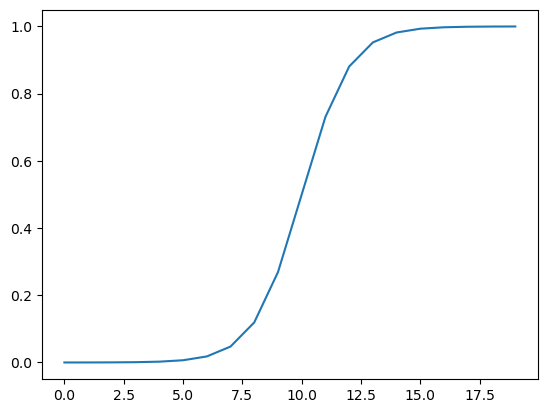

In [55]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

- Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud and not fraud)
- Multi-class classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

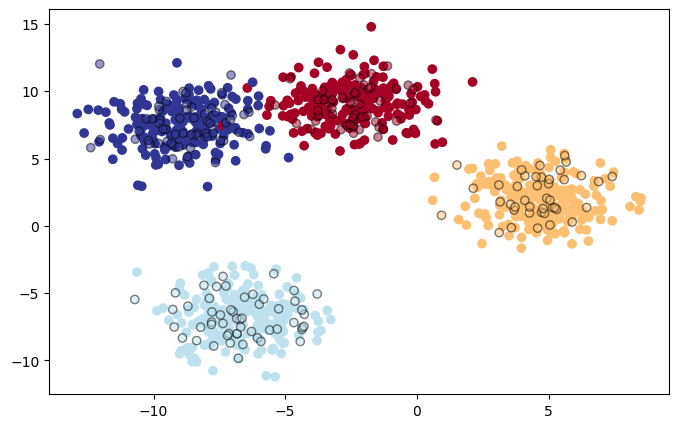

In [56]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,  # give the clusters a little shakeup
    random_state=RANDOM_SEED,
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(8, 5))
plt.scatter(X_blob_train[:, 0], X_blob_train[:, 1], c=y_blob_train, cmap=plt.cm.RdYlBu)
plt.scatter(
    X_blob_test[:, 0],
    X_blob_test[:, 1],
    c=y_blob_test,
    cmap=plt.cm.RdYlBu,
    edgecolors="black",
    alpha=0.5,
)

### 8.2 Building a multi-class classification model in PyTorch

In [57]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [58]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Numberr of hidden units between layers, default 8

        Returns:

        Example:

        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

###  8.3 Create a loss function and an optimizer for a multi-class classification model

In [59]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(
    params=model_4.parameters(), lr=0.1
)  # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediciton probabilities and then to prediction labels

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)


In [60]:
# Get some raw outputs of our model
model_4(X_blob_test.to(device))

# w
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
    # y_pred = torch.round(torch.softmax(logits, dim=1))
y_logits[:10]
# pred

# model_4(X_blob_test.to(device))

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [61]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [62]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [63]:
# Convert our model's prediction probabilities to prediction label
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 8.5 Createing a training loop for a multi-class PyTorch model

In [64]:
# Fit he multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data to a traget device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Setup optimizer and loss fn

# Train model
for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)  # dapat y_pred
    # loss = loss_fn(y_pred, y_blob_train) #dapat y_pred
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%"
        )

torch.float32 torch.int64
Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torc

### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [65]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [66]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

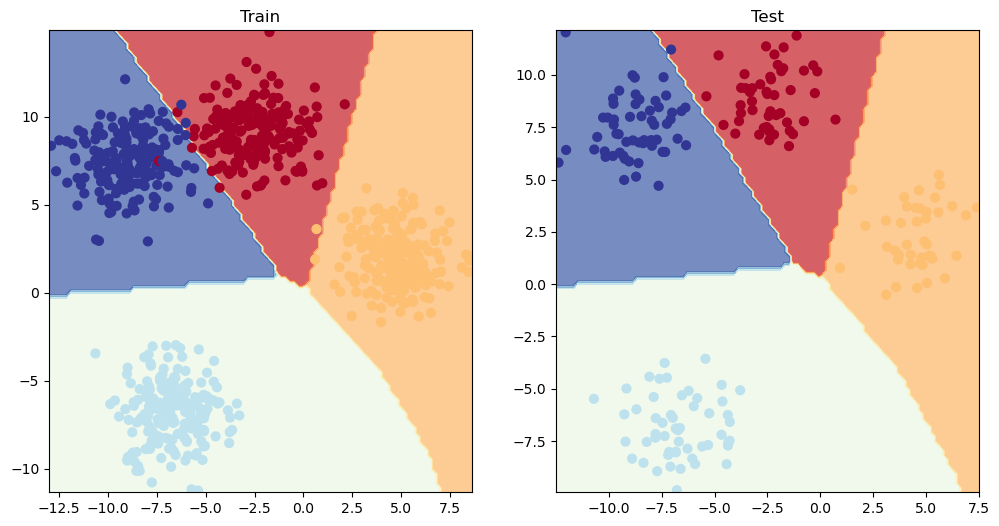

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics ... (to evaluate our classification model)

- Accuracy - out of 100 samples, how many does our model get right?
- Precision
- Recall
- F1-score
- Confusion matrix
- Classification report

Extra read:
https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics

In [68]:
!pip install torchmetrics

In [69]:
from torchmetrics import Accuracy

# Setuip metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises and Extra-curriculum

see exercises and extra-curriculum